# Topic modelling
## Importing data
This dataset consist of speach given by different presidents of united states of america from 1709 to 2022.

In [1]:
import pandas as pd
file = "custom_data.csv"
df = pd.read_csv(file)
df.head(10)

Unnamed: 0 president  year  \
0           0     Adams  1797   
1           1     Adams  1798   
2           2     Adams  1799   
3           3     Adams  1800   
4           4     Adams  1825   
5           5     Adams  1826   
6           6     Adams  1827   
7           7     Adams  1828   
8           8    Arthur  1881   
9           9    Arthur  1882   

                                              speech  
0  Gentlemen of the Senate and Gentlemen of the H...  
1  Gentlemen of the Senate and Gentlemen of the H...  
2  Gentlemen of the Senate and Gentlemen of the H...  
3  Gentlemen of the Senate and Gentlemen of the H...  
4  Fellow Citizens of the Senate and of the House...  
5  Fellow Citizens of the Senate and of the House...  
6  Fellow Citizens of the Senate and of the House...  
7  Fellow Citizens of the Senate and of the House...  
8  To the Senate and House of Representatives of ...  
9  To the Senate and House of Representatives of ...

In [2]:
print(repr(df.iloc[10]["speech"][0:400]))
print(repr(df.iloc[60]["speech"][0:400]))

'To the Congress of the United States:\n\nAt the threshold of your deliberations I congratulate you upon the\nfavorable aspect of the domestic and foreign affairs of this Government.\n\nOur relations with other countries continue to be upon a friendly footing.\nWith the Argentine Republic, Austria, Belgium, Brazil, Denmark, Hayti,\nItaly, Santo Domingo, and Sweden and Norway no incident has occurred which'
'To the Congress of the United States:\n\nThe opening of this new year must arouse in us all grateful thanks to a\nkind Providence whose protection has been ever present and whose bounty has\nbeen manifold and abundant. The State of the Union today demonstrates what\ncan be accomplished under God by a free people; by their vision, their\nunderstanding of national problems, their initiative, their self-re'


In [3]:
df.isna().sum()

Unnamed: 0    0
president     0
year          0
speech        1
dtype: int64

In [4]:
df['speech'].fillna('unknown', inplace=True)

## Splitting speech into sentence

In [5]:
import re
df["paragraphs"] = df["speech"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords),min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['speech'])
tfidf_text_vectors.shape

C:\Users\rohit\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(228, 10707)

In [7]:
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year }
                             for paragraphs, year in zip(df["paragraphs"], df["year"])
                             for paragraph in paragraphs if paragraph])
paragraph_df.head(10)

text  year
0  Gentlemen of the Senate and Gentlemen of the H...  1797
1  Although I can not yet congratulate you on the...  1797
2  Our envoys extraordinary to the French Republi...  1797
3  It may be confidently asserted that nothing ha...  1797
4  Indeed, whatever may be the issue of the negot...  1797
5  The commerce of the United States is essential...  1797
6  The faith of society is pledged for the preser...  1797
7  I have entertained an expectation that it woul...  1797
8  In connection with this unpleasant state of th...  1797
9  The commissioners appointed under the 5th arti...  1797

## Getting TFIDF of sentences

In [8]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(stopwords),min_df=5, max_df=0.7)
tfidf_para_vectors =tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

C:\Users\rohit\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(21787, 11398)

## NMF

In [9]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

## Getting topics

In [11]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out()) 



Topic 00
  silver (0.32)
  gold (0.29)
  secretary (0.28)
  department (0.25)
  cent (0.25)

Topic 01
  program (0.65)
  programs (0.57)
  economic (0.51)
  billion (0.48)
  help (0.40)

Topic 02
  economic (0.42)
  agriculture (0.34)
  veterans (0.30)
  relief (0.28)
  banks (0.28)

Topic 03
  spain (0.26)
  vessels (0.26)
  british (0.24)
  treaty (0.23)
  militia (0.22)

Topic 04
  interstate (0.31)
  man (0.28)
  corporations (0.26)
  conditions (0.26)
  islands (0.21)

Topic 05
  fighting (0.46)
  production (0.43)
  1942 (0.37)
  forces (0.35)
  japanese (0.34)

Topic 06
  mexico (0.46)
  constitution (0.37)
  treasury (0.27)
  treaty (0.25)
  texas (0.24)

Topic 07
  iraq (1.11)
  terrorists (0.80)
  iraqi (0.64)
  tonight (0.55)
  help (0.52)

Topic 08
  00 (2.00)
  treaty (0.46)
  international (0.33)
  consular (0.32)
  diplomatic (0.31)

Topic 09
  ve (0.83)
  tonight (0.83)
  jobs (0.68)
  americans (0.64)
  let (0.57)


In [12]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  government (1.25)
  public (0.99)
  country (0.57)
  national (0.44)
  law (0.42)

Topic 01
  000 (12.14)
  estimated (0.88)
  500 (0.69)
  debt (0.58)
  nearly (0.57)

Topic 02
  america (7.61)
  god (2.28)
  bless (2.12)
  thank (1.61)
  tonight (0.98)

Topic 03
  states (2.95)
  united (2.66)
  treaty (0.92)
  relations (0.56)
  government (0.55)

Topic 04
  world (3.41)
  peace (2.22)
  nations (1.59)
  free (1.05)
  war (0.96)

Topic 05
  year (5.62)
  fiscal (2.34)
  expenditures (1.59)
  receipts (1.28)
  june (1.19)

Topic 06
  congress (4.42)
  president (1.16)
  session (1.03)
  act (0.91)
  shall (0.91)

Topic 07
  people (4.88)
  american (3.44)
  know (0.63)
  work (0.63)
  let (0.53)

Topic 08
  new (1.30)
  health (0.91)
  tax (0.82)
  help (0.74)
  jobs (0.74)

Topic 09
  department (1.95)
  war (1.82)
  service (1.74)
  navy (1.50)
  report (1.45)


## Getting length of topics

In [13]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([ 8.5122849 , 12.69011379,  9.16164027, 14.51042779,  9.62234646,
        6.53482359, 15.64323196,  5.45393467,  4.12352683, 13.74766975])

In [14]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0


array([11.42374967,  5.07542666,  6.96416263, 11.11281776, 11.3683901 ,
        8.34018539, 11.50249675, 10.42970255, 13.21698322, 10.56608527])

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_


C:\Users\rohit\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(21787, 11398)

## LDA para model

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [19]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  united (2.19)
  states (2.15)
  government (1.55)
  treaty (1.07)
  american (0.80)

Topic 01
  law (1.17)
  service (1.10)
  congress (0.92)
  officers (0.72)
  department (0.65)

Topic 02
  government (1.35)
  public (1.04)
  business (1.00)
  money (1.00)
  banks (0.97)

Topic 03
  people (1.56)
  american (1.01)
  america (0.89)
  new (0.89)
  americans (0.78)

Topic 04
  world (2.98)
  peace (1.68)
  nations (1.55)
  war (1.13)
  america (0.96)

Topic 05
  government (1.23)
  federal (1.10)
  congress (1.07)
  public (0.85)
  national (0.82)

Topic 06
  country (1.40)
  foreign (1.09)
  revenue (0.99)
  tariff (0.97)
  duties (0.93)

Topic 07
  navy (1.70)
  naval (1.05)
  ships (0.92)
  vessels (0.87)
  war (0.83)

Topic 08
  000 (4.40)
  year (3.73)
  fiscal (1.27)
  treasury (1.14)
  expenditures (1.06)

Topic 09
  states (2.28)
  government (1.76)
  congress (1.27)
  united (1.16)
  people (0.95)


In [20]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([12.533034  , 11.63355937,  5.40594409, 18.04099173, 11.69847785,
       10.28412156,  5.48370331,  5.12271155,  7.49663547, 12.30082107])

## pyLDAvis

In [21]:
import pyLDAvis

In [22]:
import pyLDAvis.lda_model

lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

## Wordcloud of topics

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')


C:\Users\rohit\AppData\Local\Temp\ipykernel_32064\3513515901.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## nmf wordcloud

C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\U

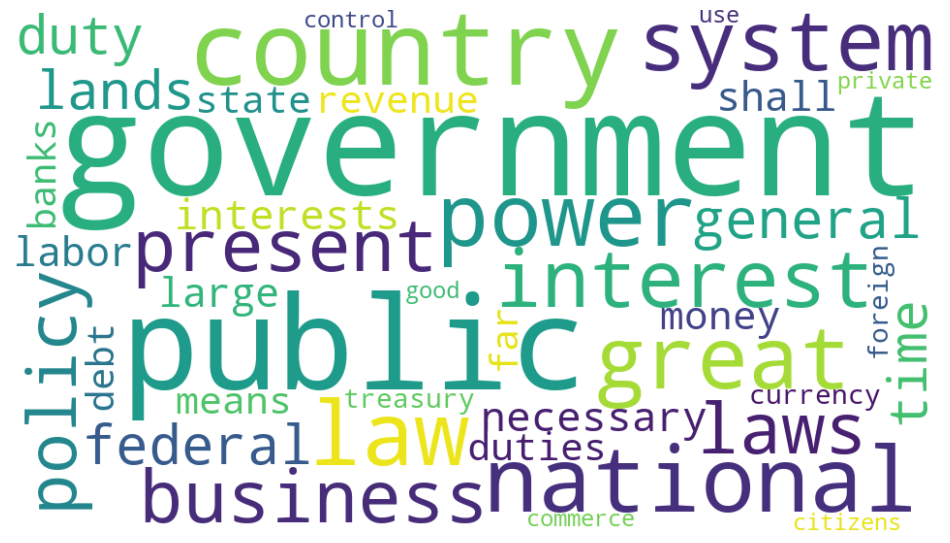

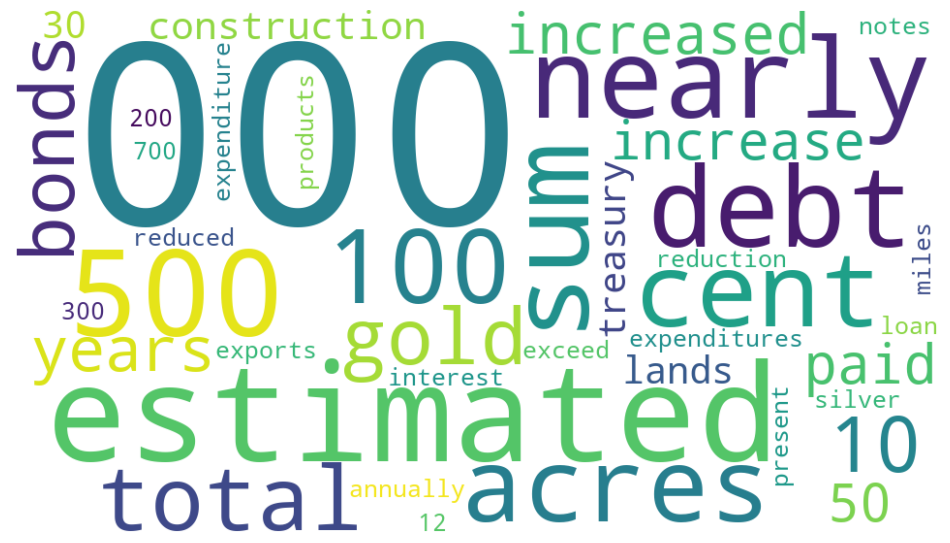

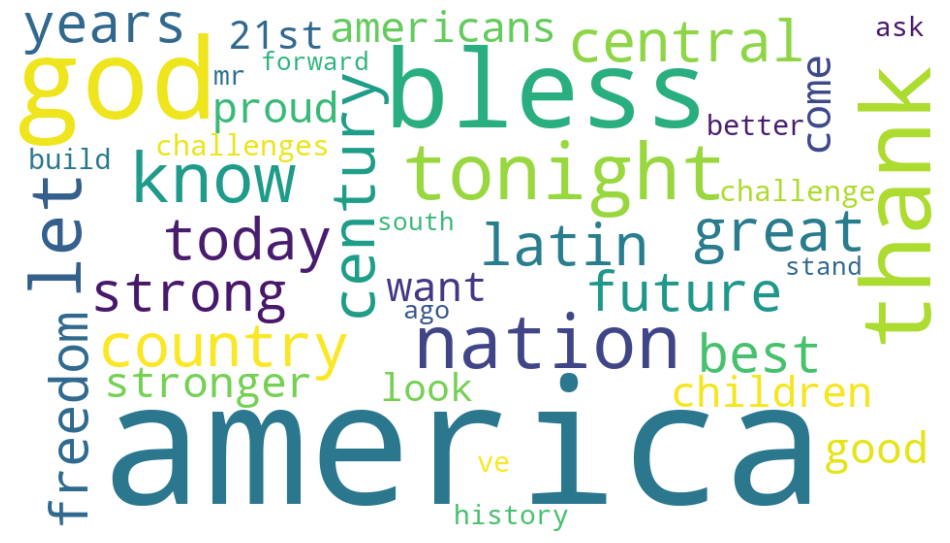

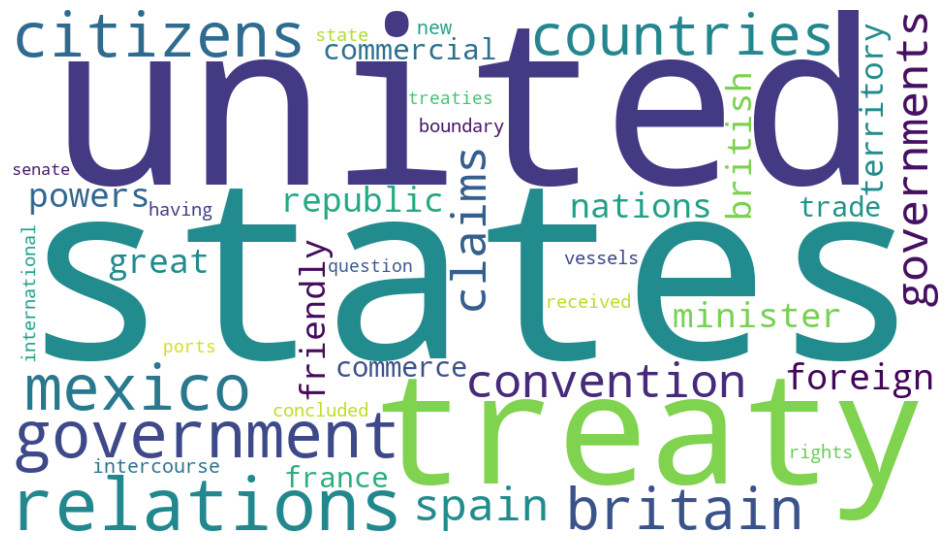

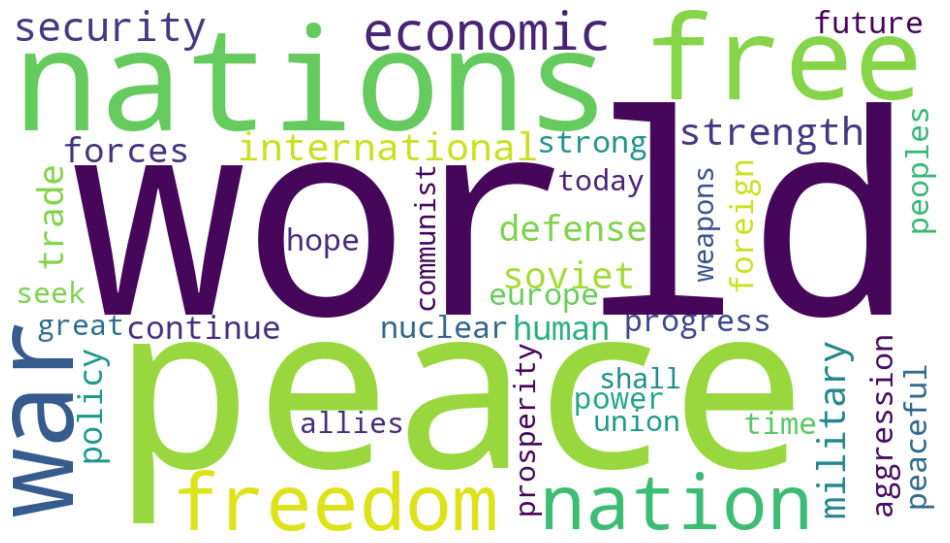

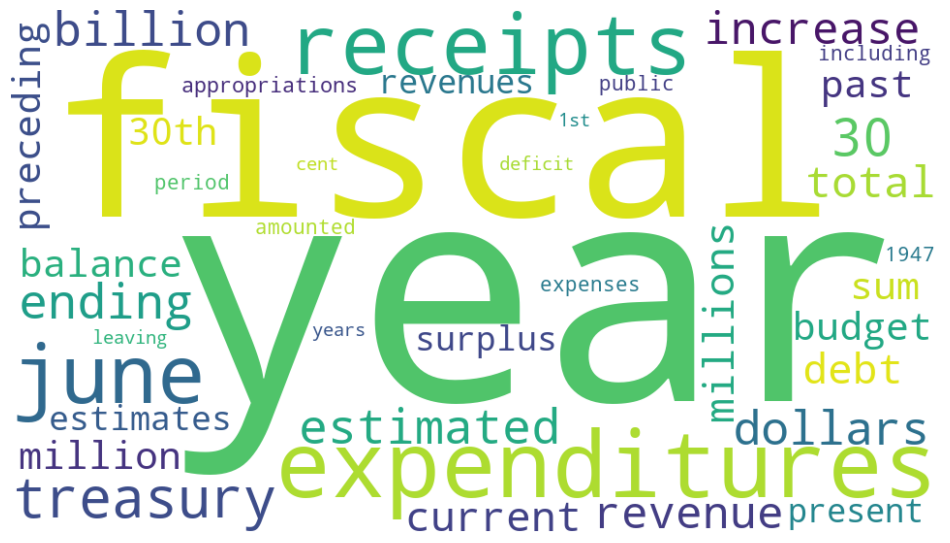

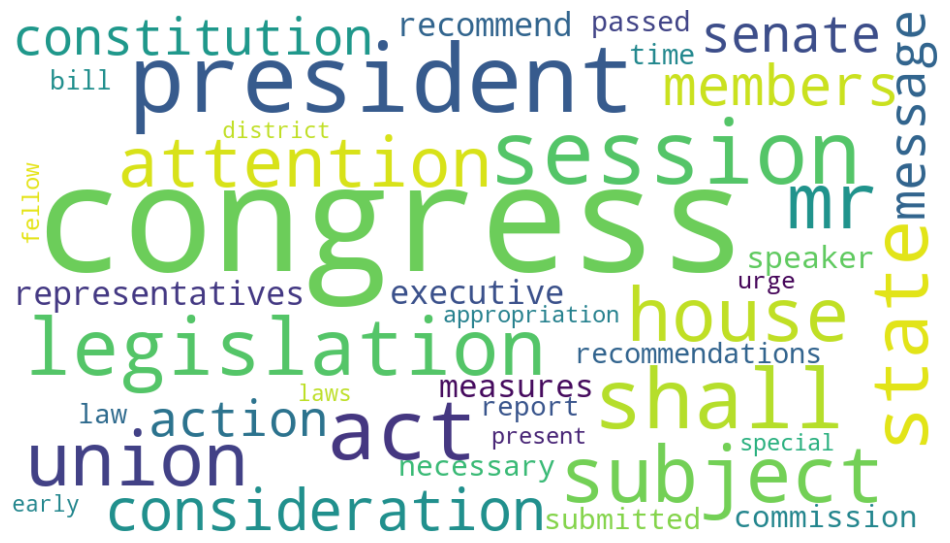

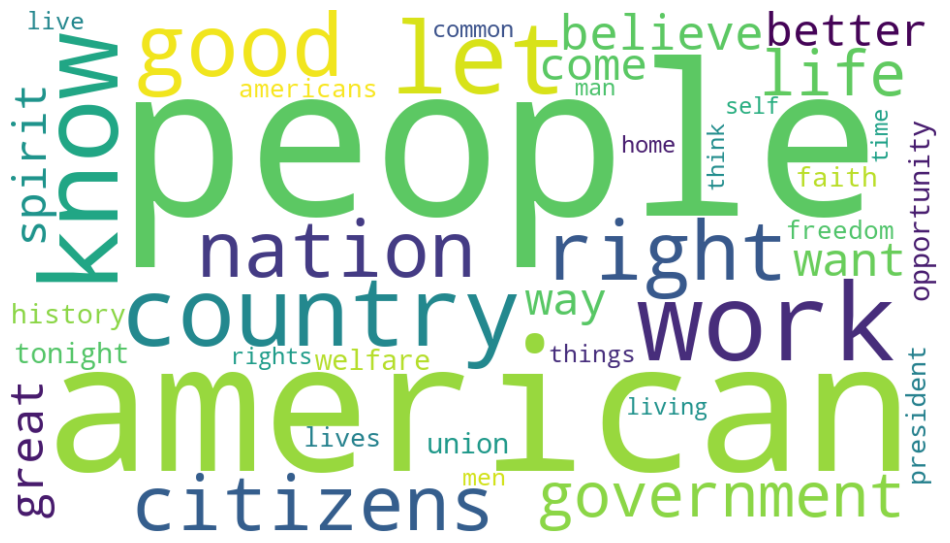

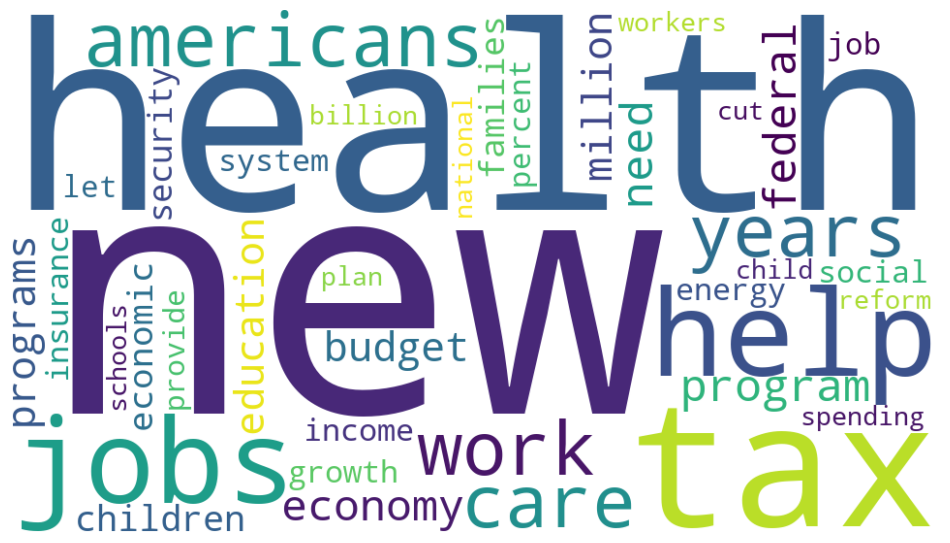

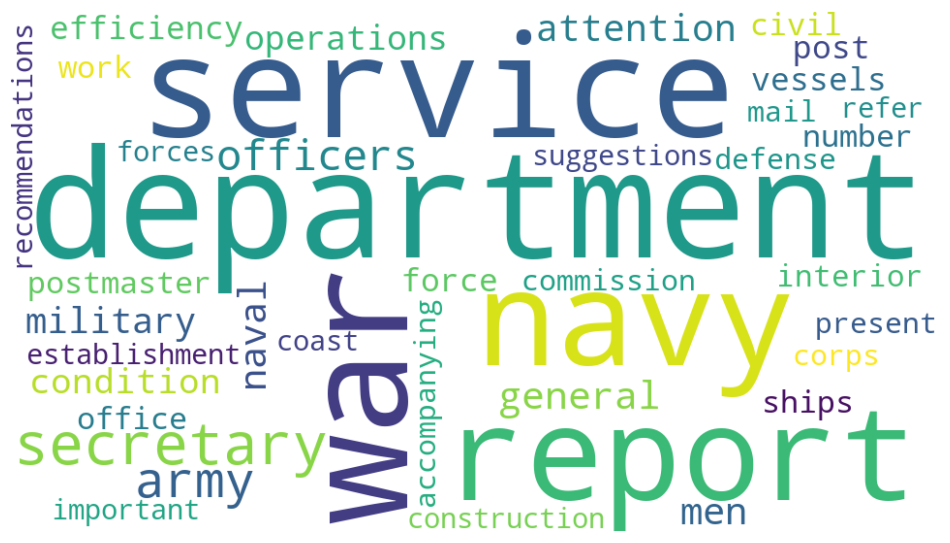

In [24]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

## lda wordcloud

C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\rohit\anaconda3\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\U

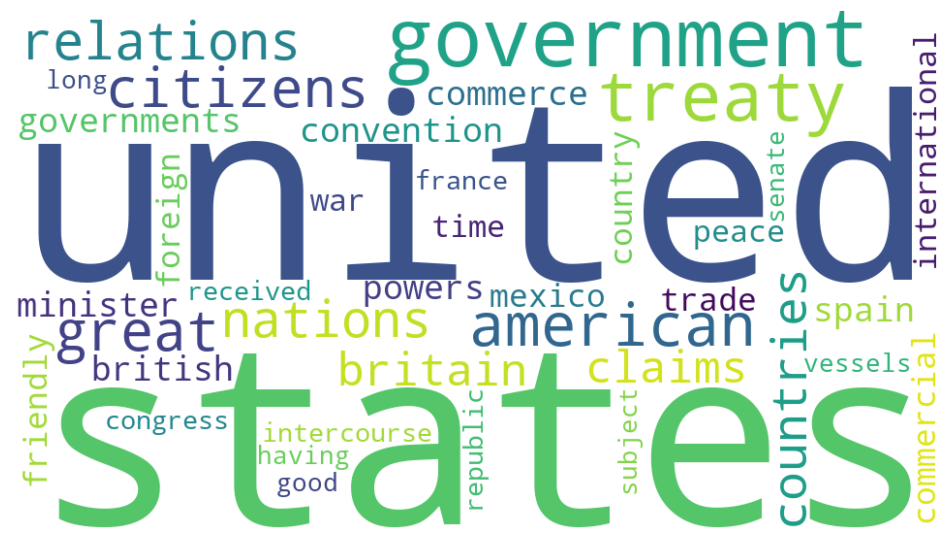

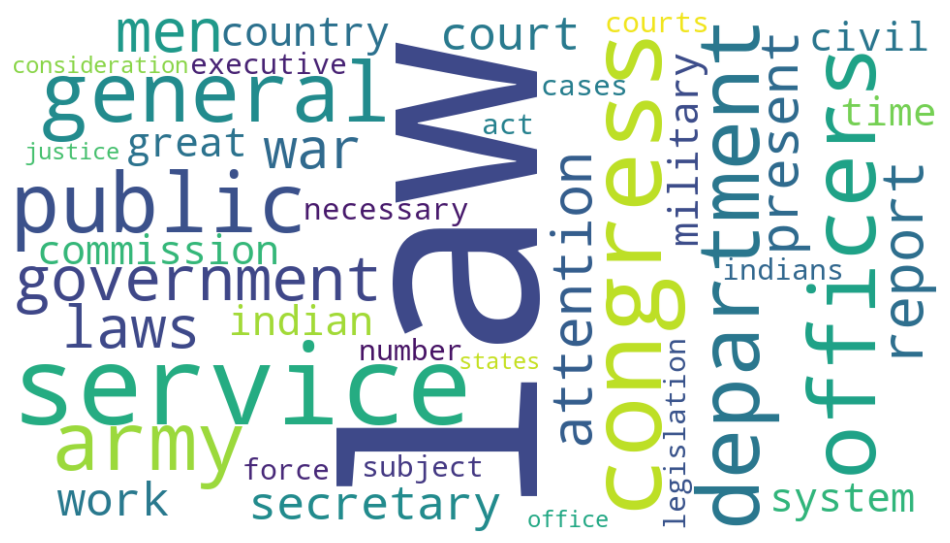

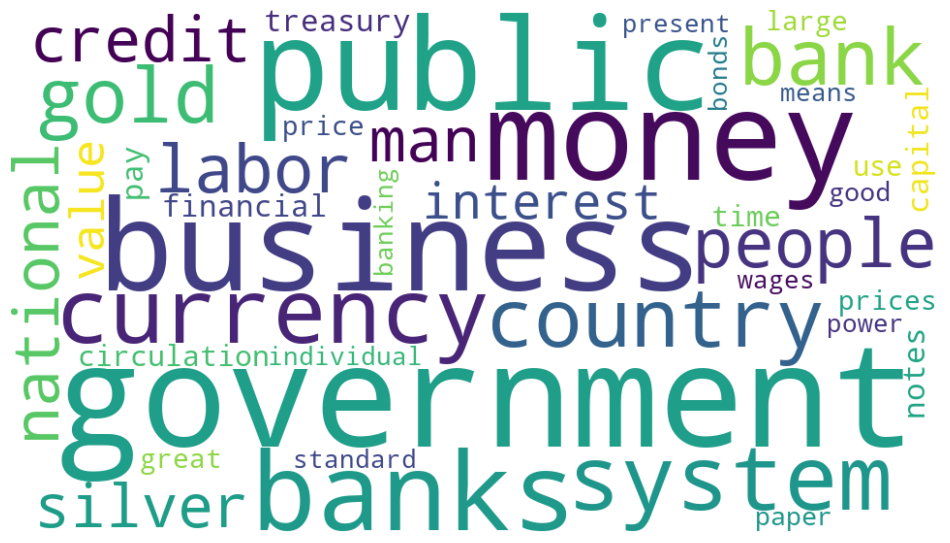

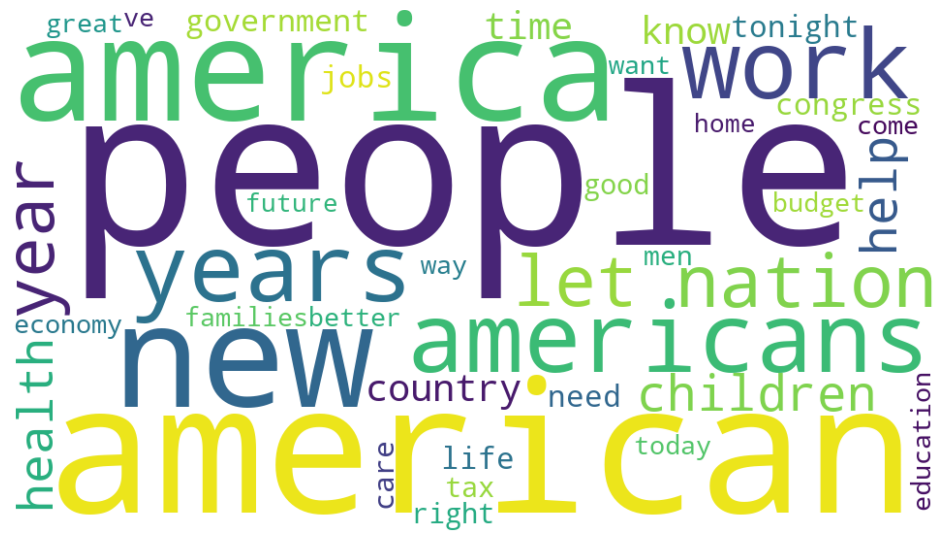

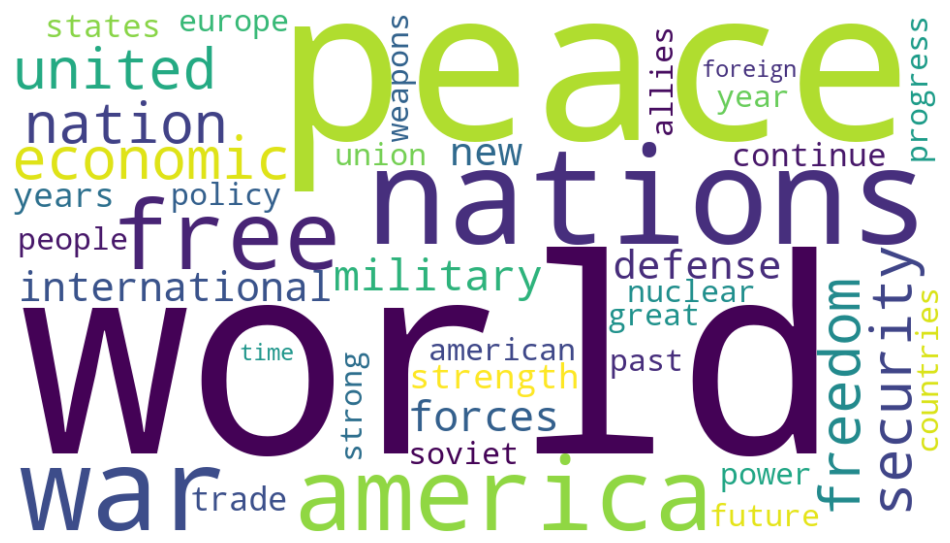

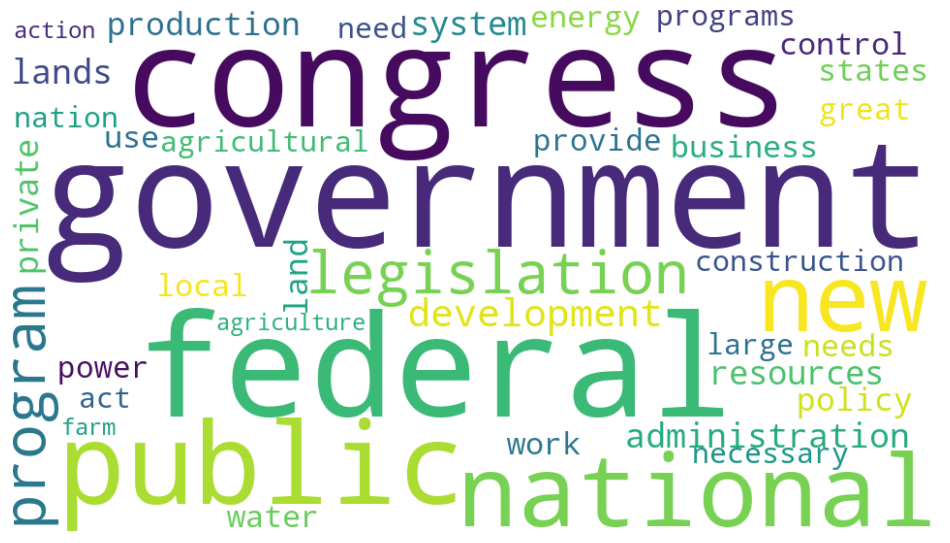

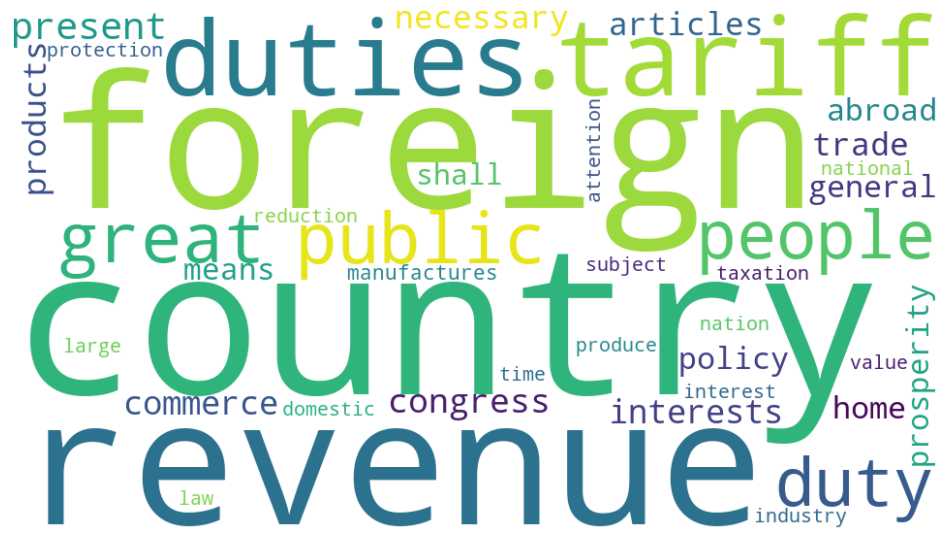

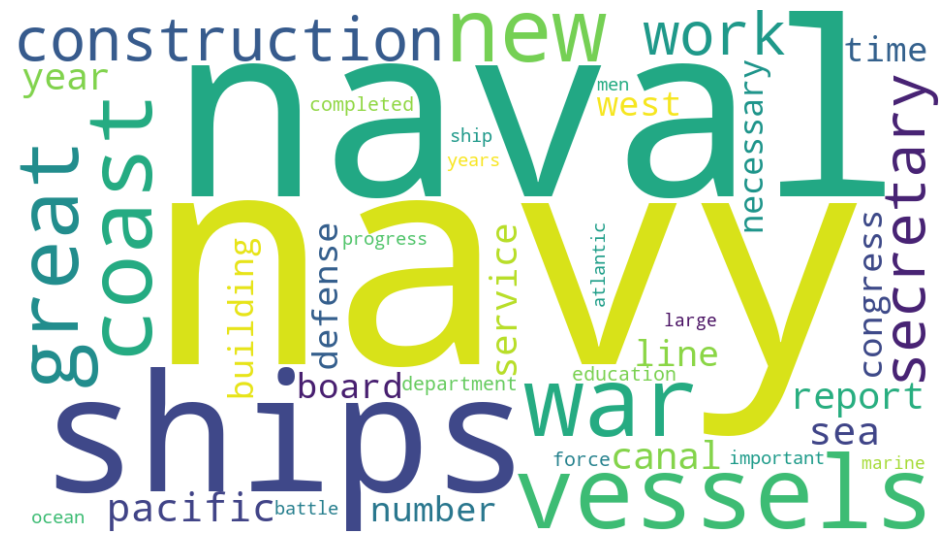

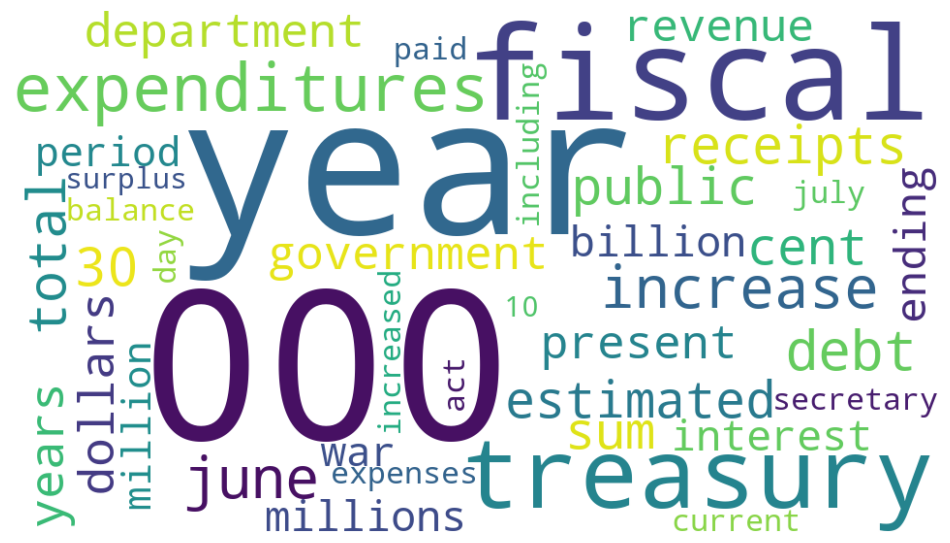

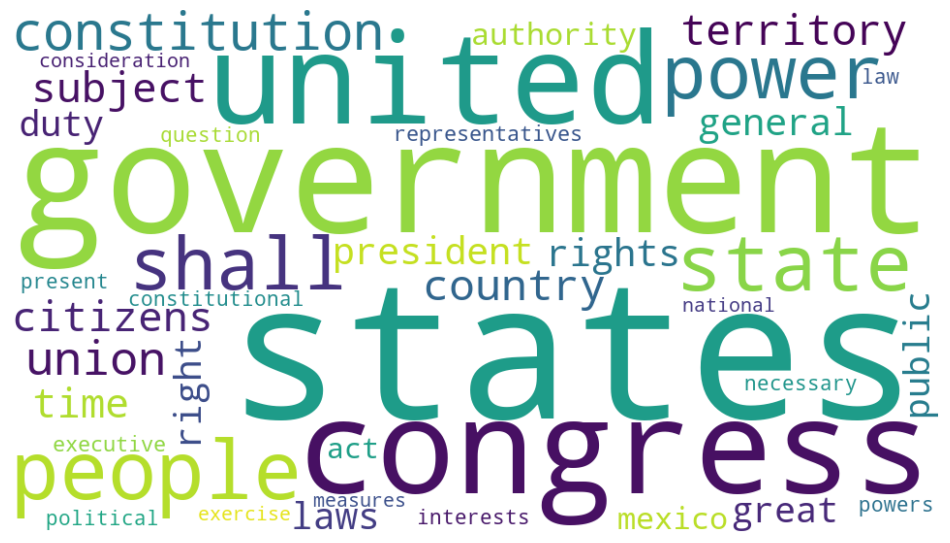

In [25]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

## Analysing by joining top 2 words

In [26]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

In [27]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

C:\Users\rohit\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\rohit\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\rohit\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\rohit\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. P

  0%|          | 0/228 [00:00<?, ?it/s]

<Axes: xlabel='year'>

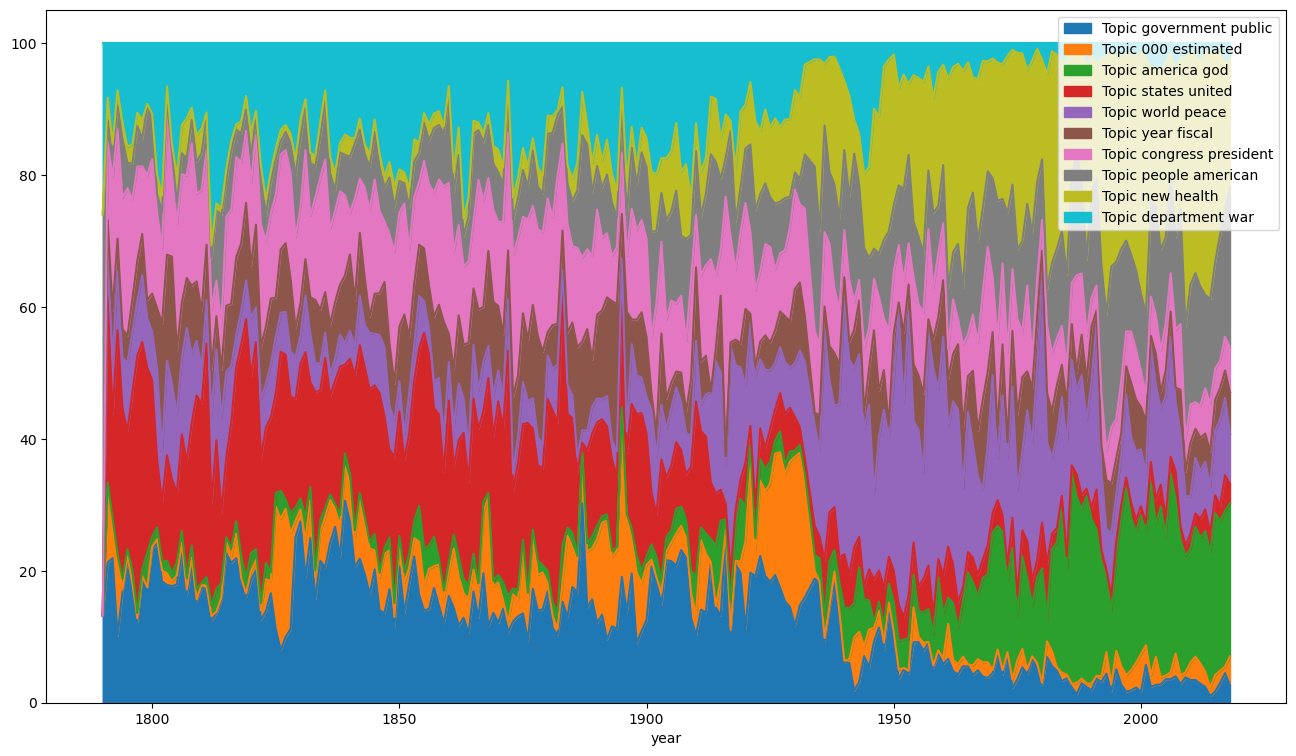

In [28]:
import matplotlib.pyplot as plt
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))